In [2]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile

In [3]:
trainDir = 'train/'
samples, sample_rate = librosa.load(trainDir+'bed/00176480_nohash_0.wav', sr = 16000)
ipd.Audio(samples, rate=sample_rate)
print(sample_rate)

16000


In [4]:
samples = librosa.resample(samples, orig_sr=sample_rate,target_sr=8000)
ipd.Audio(samples, rate=8000)

In [5]:
labels=os.listdir(trainDir)

In [6]:
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(trainDir + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))

In [7]:
labels=["bed", "bird", "cat", "dog", "down", "eight", "five", "four"]

(array([2.0000e+00, 6.0000e+00, 4.7000e+01, 3.0000e+01, 1.0600e+02,
        1.6300e+02, 2.5500e+02, 2.1900e+02, 3.7400e+02, 1.5161e+04]),
 array([0.384 , 0.4456, 0.5072, 0.5688, 0.6304, 0.692 , 0.7536, 0.8152,
        0.8768, 0.9384, 1.    ]),
 <BarContainer object of 10 artists>)

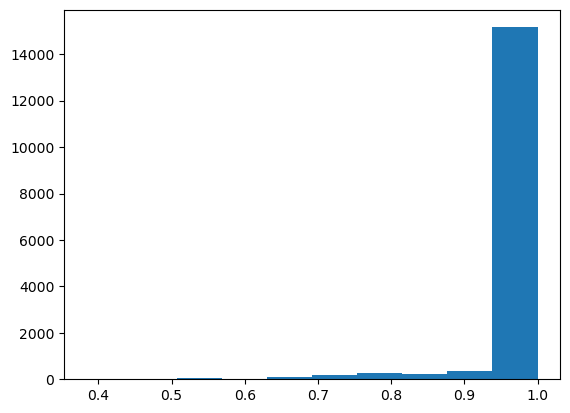

In [8]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(trainDir + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(trainDir + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [9]:
trainDir = 'train/'
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(trainDir + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(trainDir + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, orig_sr=sample_rate, target_sr=8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

bed
bird
cat
dog
down
eight
five
four


In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)
print(classes)

['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four']


In [11]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, num_classes=len(labels))


In [12]:
all_wave = np.array(all_wave).reshape(-1,8000,1)


In [13]:
print(all_wave.shape)
print(y.shape)

(14649, 8000, 1)
(14649, 8)


In [14]:

from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)


In [15]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1  (None, 2662, 8)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 884, 16)           0         
 g1D)                                                        

In [16]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [17]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('voiceRecModel.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
print(x_tr.shape, x_val.shape, y_tr.shape, y_val.shape)

(11719, 8000, 1) (2930, 8000, 1) (11719, 8) (2930, 8)


In [18]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))


Epoch 1/100
367/367 [==============================] - 61s 158ms/step - loss: 1.8623 - accuracy: 0.2738 - val_loss: 1.6073 - val_accuracy: 0.4092
Epoch 2/100
367/367 [==============================] - 63s 172ms/step - loss: 1.4741 - accuracy: 0.4358 - val_loss: 1.4618 - val_accuracy: 0.4399
Epoch 3/100
367/367 [==============================] - 56s 153ms/step - loss: 1.2370 - accuracy: 0.5422 - val_loss: 1.0860 - val_accuracy: 0.6321
Epoch 4/100
367/367 [==============================] - 56s 152ms/step - loss: 1.0263 - accuracy: 0.6344 - val_loss: 0.8598 - val_accuracy: 0.6959
Epoch 5/100
367/367 [==============================] - 56s 152ms/step - loss: 0.8463 - accuracy: 0.7007 - val_loss: 0.8555 - val_accuracy: 0.6962
Epoch 6/100
367/367 [==============================] - 57s 156ms/step - loss: 0.7200 - accuracy: 0.7511 - val_loss: 0.8008 - val_accuracy: 0.7290
Epoch 7/100
367/367 [==============================] - 57s 155ms/step - loss: 0.6585 - accuracy: 0.7721 - val_loss: 0.6721 -

367/367 [==============================] - 57s 155ms/step - loss: 0.1866 - accuracy: 0.9351 - val_loss: 0.4439 - val_accuracy: 0.8782
Epoch 28/100
367/367 [==============================] - 56s 153ms/step - loss: 0.2168 - accuracy: 0.9282 - val_loss: 0.3779 - val_accuracy: 0.8894
Epoch 29/100
367/367 [==============================] - 56s 152ms/step - loss: 0.2053 - accuracy: 0.9328 - val_loss: 0.3434 - val_accuracy: 0.8966
Epoch 30/100
367/367 [==============================] - 56s 153ms/step - loss: 0.1999 - accuracy: 0.9358 - val_loss: 0.3727 - val_accuracy: 0.8901
Epoch 31/100
367/367 [==============================] - 57s 154ms/step - loss: 0.1781 - accuracy: 0.9410 - val_loss: 0.4278 - val_accuracy: 0.8819
Epoch 32/100
367/367 [==============================] - 56s 154ms/step - loss: 0.1806 - accuracy: 0.9392 - val_loss: 0.4700 - val_accuracy: 0.8751
Epoch 33/100
367/367 [==============================] - 57s 155ms/step - loss: 0.1791 - accuracy: 0.9408 - val_loss: 0.4290 - val_a

KeyboardInterrupt: 

In [25]:
model.save("voiceRecModel.hdf5")

# Model Test

In [28]:
from keras.models import load_model

model = load_model("voiceRecModel.hdf5")

In [29]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)



Audio: four


In [30]:
print("Text:",predict(samples))

1/1 [==============================] - 0s 115ms/step
Text: four
